## Generative adversarial networks
### Generating of MNIST digits with a GAN

Setting up

In [1]:
!pip3 install tqdm
!pip3 install torchsummary
!pip3 install pytorch-fid

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.nn.utils.parametrizations as parametrizations
from torchsummary import summary
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from torch.autograd import grad as torch_grad
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets
from torchvision.utils import save_image
import pytorch_fid.fid_score as fid
from torchvision.datasets import ImageFolder
import os
import glob
import subprocess
import re
import time
import os
import zipfile 
import gdown
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

Check that we're running on GPU, and initialize our device

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    print("The code will run on GPU for MacOS devices with Metal programming framework.")
    device = torch.device('mps')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')
print("Device: {}".format(device))

The code will run on GPU.
Device: cuda


Setup our MNIST dataloaders

In [82]:
batch_size = 64               # Batch size
nz = 100                      # Size of the input noise vector
ngf = 24                      # Scale number of conv filters in generator
ndf = 24                      # Scale number of conv filters in discriminator
nc = 3                        # Number of channels in the output image (RGB or black and white ecc)
model_input_size = 32         # Used to determine which model to use, options: (28, 32)
datasetName = "CELEBA"         # Either MNIST, FashionMNIST, CIFAR10, CELEBA
useLSGAN = False              # If enabled uses least squared criterion instead of binary cross entropy (only if useWGAN=False)
useWGAN = True                # If true make the GAN a WGAN
weights_clip_value = 0.01     # When using WGAN clip weights of discriminator in range (-clip, +clip)
useWeightClipping = False
useGradientPenality = True
useSpectralNormalization = False

In [72]:
# MNIST dataset
if datasetName == "MNIST":
  trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
elif datasetName == "FashionMNIST":
  trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testset = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
elif datasetName == "CIFAR10":
  trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                       ]))
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
elif datasetName == 'CELEBA':
    trainset = ImageFolder('./data/celeba/', transform=transforms.Compose([
        transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                       ]))
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

mv: cannot stat ‘./data/celeba/img_align_celeba’: No such file or directory


## DCGAN

Implement **generator** network.

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [83]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.input_size = input_size
        
        self.reshapeModule = nn.Linear(nz, ngf * 8 * 4 * 4)

        self.dcmodel = 0
        if (model_input_size == 28):
          self.dcmodel = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
          )
        elif (model_input_size == 32):
          self.dcmodel = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( ngf * 8, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.Conv2d( ngf * 2, nc, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
          )


    def forward(self, x):
        # FEEDFOREWARD MODEL
        #x = x.view(x.size(0), -1)
        #x = self.fullyconnected(x)
        #x = x.view(x.size(0), 1, 28, 28)

        # CONVOLUTIONAL MODEL
        x = x.view(x.size(0), -1)
        x = self.reshapeModule(x)
        x = x.view(x.size(0), ngf * 8, 4, 4)
        x = self.dcmodel(x)
        return x

Implement **discriminator** network.

In [84]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        if (useSpectralNormalization == False):
            self.outputDense = nn.Linear(ndf * 8 * 4 * 4, 1)
        else:
            self.outputDense = parametrizations.spectral_norm(nn.Linear(ndf * 8 * 4 * 4, 1))
            
        self.dcmodel = 0
        if (model_input_size == 28):
          self.dcmodel = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 3, 1, 0, bias=False),
          )
        elif (model_input_size == 32 and useSpectralNormalization == False):
          self.dcmodel = nn.Sequential(
            nn.Conv2d(nc, ndf * 2, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nc) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LayerNorm([ndf * 4, 16, 16]),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False),
            nn.LayerNorm([ndf * 4, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
        )
        elif (model_input_size == 32 and useSpectralNormalization == True):
            self.dcmodel = nn.Sequential(
            parametrizations.spectral_norm(nn.Conv2d(nc, ndf * 2, 3, 1, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (nc) x 32 x 32
            parametrizations.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LayerNorm([ndf * 4, 16, 16]),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            parametrizations.spectral_norm(nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)),
            nn.LayerNorm([ndf * 4, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            parametrizations.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            )
    
    def forward(self, x):
        # FEEDFOREWARD MODEL
        #x = x.view(x.size(0), -1)
        #x = self.fulluconnected(x)

        # CONVOLUTIONAL MODEL
        x = self.dcmodel(x)
        x = x.view(x.size(0), -1)
        x = self.outputDense(x)
        if (not useWGAN and not useLSGAN):
          x = torch.sigmoid(x)
        x = x.view(x.size(0), 1)        
        return x

In [10]:
def gradient_penalty(d, real_data, generated_data):
    if (str(device) == 'cuda'):
        use_cuda = True
    else:
        use_cuda = False
    gp_weight = 10
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    if use_cuda:
      alpha = alpha.cuda()
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if use_cuda:
      interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = d(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return gp_weight * ((gradients_norm - 1) ** 2).mean()

FID function based on inception V3

In [ ]:
def compute_fid(model, distribution_size=20):
    model.eval()

    # Create folders if not existing
    if (not os.path.exists("dataset_real")):
        os.mkdir("./dataset_real")
    if (not os.path.exists("dataset_fake")):
        os.mkdir("./dataset_fake")

  # Empty the folders
    files = glob.glob('dataset_real/*')
    for f in files:
        os.remove(f)
    files = glob.glob('dataset_fake/*')
    for f in files:
        os.remove(f)

    # Get images from dataset
    print("Generating images for FID calculation...")
    singleLoader = DataLoader(dataset=trainset, shuffle=True, batch_size=1)
    for i in range(distribution_size):
        # Save real
        image, raget = next(iter(singleLoader))
        x_changed = image[0].cpu().squeeze() / 2.0 + 0.5
        save_image(x_changed, "dataset_real/real_{}.png".format(i))

        # Save fake
        target_image = model(make_noise(1, model.input_size)).detach()
        target_image = target_image[0].cpu().squeeze() / 2 + 0.5
        #target_image = torch.randn(3, 32, 32)
        save_image(target_image, "dataset_fake/fake_{}.png".format(i))
    print("Done")
    
    # run FID script
    num_avail_cpus = len(os.sched_getaffinity(0))
    num_workers = min(num_avail_cpus, 8)
    fidValue = fid.calculate_fid_given_paths(["./dataset_real/", "./dataset_fake/"], 50, device, 2048, num_workers)
    """
    if (use_cuda):
        params = ['python3', '-m', 'pytorch_fid', '--device', 'cuda:0', './dataset_fake/', './dataset_real/']
    else:
        params = ['python3', '-m', 'pytorch_fid', './dataset_fake/', './dataset_real/']
    result = subprocess.run(params, stdout=subprocess.PIPE)
    
    # Get last line of output and extract float value
    print(result.stdout)
    fidValue = float(re.findall("\d+\.\d+", str(result.stdout.splitlines()[-1]))[0])
    """
    
    return fidValue

Utility functions that are handy

In [12]:
def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_filled(size, value):
    data = Variable(torch.full(size, value))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

#def make_noise(batch_size, size):
#    return torch.randn(batch_size, size).to(device)

def make_noise(batch_size, size):
    return torch.randn(batch_size, size, 1, 1).to(device)
    

Create generator and discriminator 

In [85]:
d = Discriminator().to(device)
d.apply(weights_init)
summary(d, (nc, model_input_size, model_input_size))
g = Generator(nz).to(device)
g.apply(weights_init)
summary(g, (nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
         LeakyReLU-2           [-1, 48, 32, 32]               0
            Conv2d-3           [-1, 96, 16, 16]          73,728
         LayerNorm-4           [-1, 96, 16, 16]          49,152
         LeakyReLU-5           [-1, 96, 16, 16]               0
            Conv2d-6             [-1, 96, 8, 8]         147,456
         LayerNorm-7             [-1, 96, 8, 8]          12,288
         LeakyReLU-8             [-1, 96, 8, 8]               0
            Conv2d-9            [-1, 192, 4, 4]         294,912
        LeakyReLU-10            [-1, 192, 4, 4]               0
           Linear-11                    [-1, 1]           3,073
Total params: 581,905
Trainable params: 581,905
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

Train model

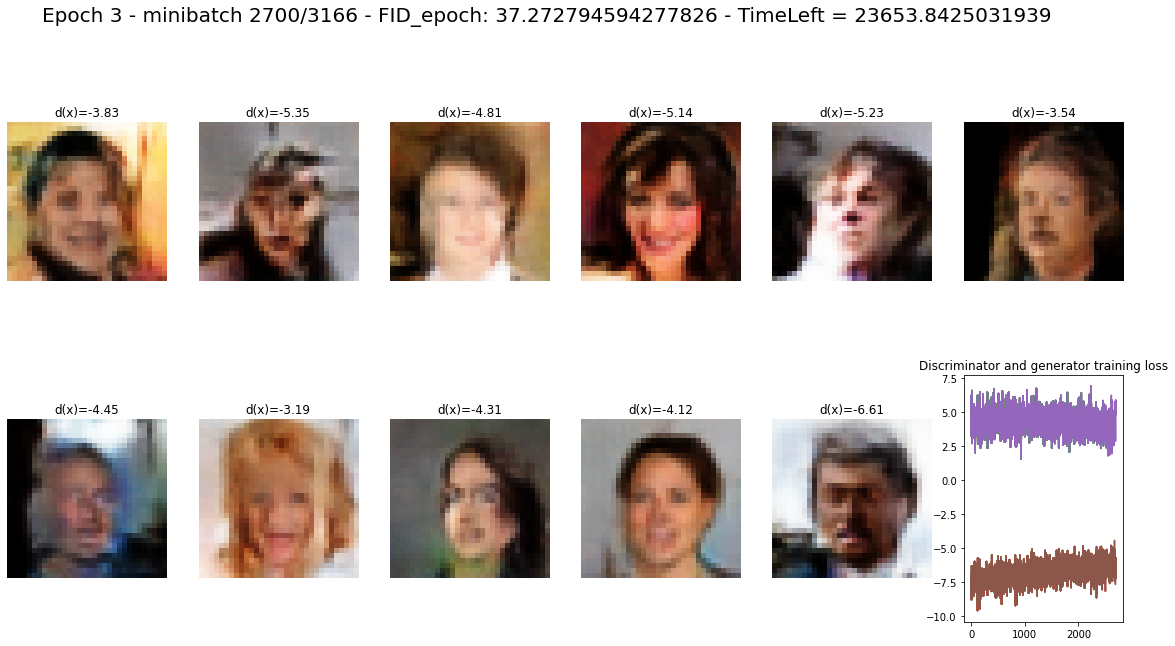

Epoch 2: g_loss: 4.27073315 d_loss: -6.84997460


In [ ]:
# Create optimizer
if (useWGAN):
  #d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
  #g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
  d_opt = torch.optim.Adam(d.parameters(), lr=0.0001, betas=(0.5, 0.999))
  g_opt = torch.optim.Adam(g.parameters(),  lr=0.0001, betas=(0.5, 0.999))
else:
  d_opt = torch.optim.Adam(d.parameters(), lr=0.0001, betas=(0.5, 0.999))
  g_opt = torch.optim.Adam(g.parameters(),  lr=0.0001, betas=(0.5, 0.999))

# Choose loss function
if (useLSGAN):
  d_loss_fun = nn.MSELoss()
else:
  d_loss_fun = nn.BCELoss()

# Setup training
images_fig = plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
if (useWGAN):
  iterations_discriminator = 5
else:
  iterations_discriminator = 1

# Set models to training mode
d.train()
g.train()
epoch_size = len(train_loader)
FIDValues = []
timePassed = time.time()
for epoch in range(num_epochs):
    # Reset
    g_loss = d_loss = 0.0
    g_losses = []
    d_losses = []
    subplots[-1].clear()

    # Save models
    torch.save(g.state_dict(), "generator.pt")
    torch.save(d.state_dict(), "discriminator.pt")

    for i in range(epoch_size):
        
        if ( ((epoch * epoch_size + i) % int(num_epochs * epoch_size / 10)) == 0):
            FIDValues.append(compute_fid(g, 4000))

            # Update FID plot
            x = np.arange(0, len(FIDValues) * 5, step=5)
            FID_fig, ax = plt.subplots(1)
            ax.plot(x, FIDValues)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('FID')
            ax.set_title('Training - FID score for each epoch')
            FID_fig.savefig("training_fid.png")
            FID_fig.clear()

        def train_discriminator(optimizer):
            
            #train discriminator to recognize real images
            loss = 0.0
            for k in range(iterations_discriminator):
                d.zero_grad() #reset gradients

                # Get batch of real images
                x, target = next(iter(train_loader))
                x_real = x.to(device)

                # Get batch of fake images
                x_fake = g(make_noise(batch_size, g.input_size))
        
                #remember to detach x_fake before using it to compute the discriminator loss
                #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
                x_fake = x_fake.detach()

                # Train discriminator on real images
                prediction_real = d(x_real)
                n_real = prediction_real.size(0) #get batch size

                # Train discriminator on fake fake images
                prediction_fake = d(x_fake)
                n_fake = prediction_fake.size(0) #get batch size

                # loss function
                if (useWGAN):
                  d_loss = -prediction_real.mean() + prediction_fake.mean()
                else:
                  d_loss = d_loss_fun(prediction_real, make_ones(n_real)) + d_loss_fun(prediction_fake, make_zeros(n_fake))

                # gradient penality
                if (useGradientPenality):
                  gp = gradient_penalty(d, x_real, x_fake)
                  d_loss += gp
                
                # Backprop
                d_loss.backward()
        
                #update weights
                optimizer.step()

                # Clip discriminator weights
                if (useWeightClipping):
                  for parm in d.parameters():
                    parm.data.clamp_(-weights_clip_value, weights_clip_value)
                
                # Update loss
                loss += d_loss.detach().cpu().numpy()
            return loss

        def train_generator(optimizer):
            g.zero_grad() #reset gradients

            x_fake = g(make_noise(batch_size, g.input_size))
        
            #train generator to fool discriminator
            prediction = d(x_fake)
            n = prediction.size(0) #get batch size
            if (useWGAN):
              g_loss = -prediction.mean() # Maximize prediction
            else:
              g_loss = d_loss_fun(prediction, make_ones(n))
            g_loss.backward()
        
            #update weights
            optimizer.step()

            return g_loss.detach().cpu().numpy()
        
        #====================
        # Update discriminator
        #====================
        #make real and fake image
        d_losses.append(train_discriminator(d_opt))
        d_loss += d_losses[-1]
        
        #========================
        # Update generator
        #========================
        #feed random noise to generator
        g_losses.append(train_generator(g_opt))
        g_loss += g_losses[-1]
        
        assert(not np.isnan(d_loss))
        #Plot results every 100 minibatches
        if i % 100 == 0:
            g.eval()
            with torch.no_grad():
                x_fake = g(make_noise(batch_size, g.input_size)).detach()
                P = d(x_fake)
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze() / 2 + 0.5 # between 0,1
                    if (nc > 1): #change format with channels in the end for imshow
                      x_fake_k = x_fake_k.swapaxes(0,1)
                      x_fake_k = x_fake_k.swapaxes(1,2)
                    if (nc == 1):
                        subplots[k].imshow(x_fake_k, cmap='gray')
                    else:
                        subplots[k].imshow(x_fake_k)
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                #subplots[-1].cla()
                subplots[-1].plot(np.arange(len(g_losses)), g_losses)
                subplots[-1].plot(np.arange(len(d_losses)), d_losses)
                #subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator and generator training loss')
                
                percentDone = (epoch * epoch_size + i + 0.01) / (num_epochs * epoch_size)
                title = 'Epoch {e} - minibatch {n}/{d} - FID_epoch: {l} - TimeLeft = {t}'.format(e=epoch+1,
                    n=i, d=epoch_size, l=FIDValues[-1], t=(((time.time() - timePassed) * (1 - percentDone)) / percentDone) )
                images_fig.suptitle(title, fontsize=20)
                display.display(images_fig)
                print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_loss/max(1, i), d_loss/max(1, i)))
                display.clear_output(wait=True)

                # Set model to train
                d.train()
                g.train()
                

In [ ]:
#g.load_state_dict(torch.load("./models/generator.pt"))
#g.load_state_dict(torch.load("./models/generator_MNIST.pt"))
#print(FIDValues)
#torch.save(g.state_dict(), "generator.pt")
#torch.save(d.state_dict(), "discriminator.pt")
np.savetxt('./results/celeba_wgangp.csv', FIDValues, delimiter=',')
FIDValues.append(compute_fid(g, 4000))
print(FIDValues[-1])
np.savetxt('./results/celeba_wgangp.csv', FIDValues, delimiter=',')

In [79]:
!ls ./results/

celeba_gan.csv		      results_celeba_WGANGP_10e.png
celeba_gansn.csv	      results_fashion.png
celeba_wgangp.csv	      results_mnist.png
results			      training_fid_celeba_GANSN.png
results_celeba_GANSN_10e.png  training_fid_celeba_WGANGP.png


In [ ]:
x = np.arange(0, len(FIDValues[2:]), step=1) + 1
FID_fig, ax = plt.subplots(1)
ax.plot(x, FIDValues[2:])
ax.set_xlabel('Epoch')
ax.set_ylabel('FID')
ax.set_title('Training - FID score for each epoch')
FID_fig.savefig("training_fid_celeba_GAN.png")
FID_fig.show()
#FID_fig.clear()

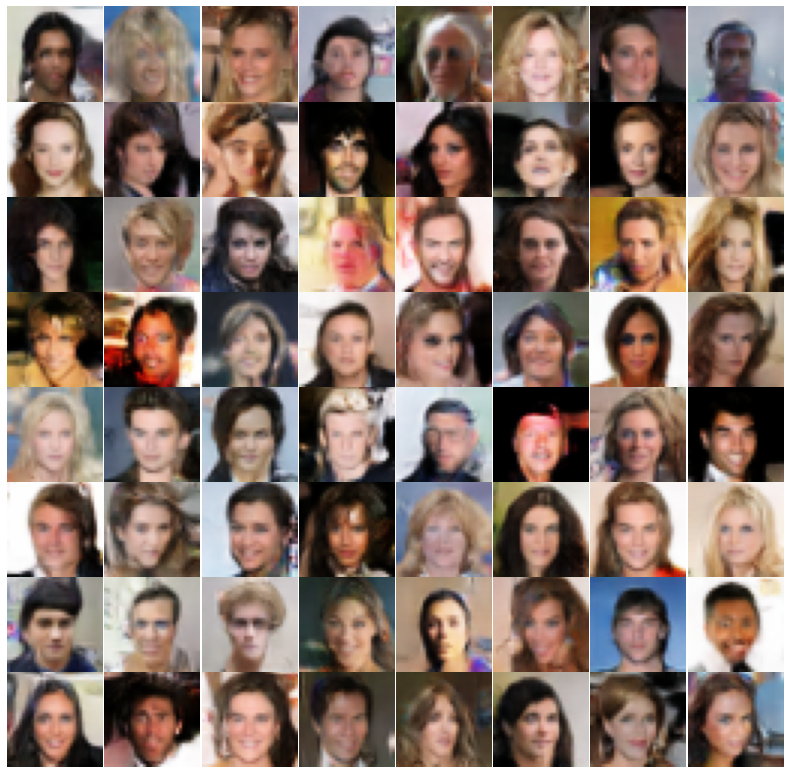

In [81]:
g.eval()
f, axs = plt.subplots(8, 8, figsize=(12, 12))
axs = axs.flatten()
plt.subplots_adjust(hspace=0, wspace=0, left=0, bottom=0,)
for ax in axs:
    target_image = g(make_noise(1, g.input_size)).detach()
    #target_image, target = next(iter(train_loader))
    target_image = target_image[0].cpu().squeeze() / 2 + 0.5
    if (nc > 1):
        target_image = target_image.swapaxes(0,1)
        target_image = target_image.swapaxes(1,2)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    if (nc == 1):
        ax.imshow(target_image, cmap='gray')
    else:
        ax.imshow(target_image)
f.savefig("results.png")
#f.show()

    

In [ ]:
!python3 -m pytorch_fid --device cuda:0 ./dataset_fake/ ./dataset_real/